# Temperature Forecasting using LSTMs

In [1]:
import os

data_dir = '/home/bss/data/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

# prep
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(len(lines))
header

420551


['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

## Plot Temperature Timeseries

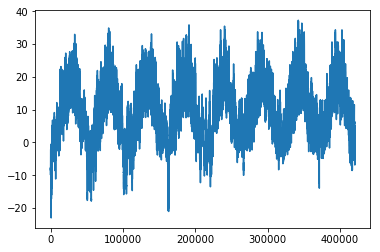

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1] #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

### First 10 days 

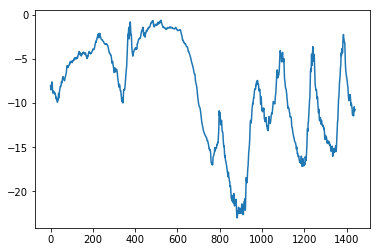

In [17]:
plt.plot(range(1440), temp[:1440])

## Preparing data

lookback = 720  -- observations go back 5 days

steps = 6 -- obs sampled one data pt per hr

delay = 144  -- targets are 24hrs in future

In [3]:
# timeseries is using a different scale -- normalize each values 
# python generator to input current array to give batches of data from recent past

# preprocess by subtracting the mean of each timeseries and divide by std dev
mean = float_data[:2000000].mean(axis=0)
float_data -= mean
std = float_data[:2000000].std(axis=0)
float_data /= std

In [4]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### Training, validation and test generators

In [5]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Non ML Baseline

Data was noramlized to center on 0 and have a std deviation of  1

In [6]:
# MAE 
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.304497124411


In [7]:
# convert mae back to celsius error
# Large average absolute error = 2.44
celsius_mae = 0.29 *std[1]
celsius_mae

2.4427730067538058

## ML Approach

Fully connected model by flattening data through 2 dense layers. Last layer without activation function (typical for regression)

In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import keras

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, 
                             steps_per_epoch=500,
          
                              epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s - loss: 1.0830 - val_loss: 0.4337
Epoch 2/20
500/500 [==============================] - 7s - loss: 0.3362 - val_loss: 0.3403
Epoch 3/20
500/500 [==============================] - 7s - loss: 0.2914 - val_loss: 0.3054
Epoch 4/20
500/500 [==============================] - 7s - loss: 0.2739 - val_loss: 0.3143
Epoch 5/20
500/500 [==============================] - 7s - loss: 0.2667 - val_loss: 0.3313
Epoch 6/20
500/500 [==============================] - 7s - loss: 0.2574 - val_loss: 0.3158
Epoch 7/20
500/500 [==============================] - 7s - loss: 0.2513 - val_loss: 0.3224
Epoch 8/20
500/500 [==============================] - 7s - loss: 0.2467 - val_loss: 0.3169
Epoch 9/20
500/500 [==============================] - 7s - loss: 0.2419 - val_loss: 0.3281
Epoch 10/20
500/500 [==============================] - 7s - loss: 0.2383 - val_loss: 0.3244
Epoch 11/20
500/500 [==============================] - 7s - loss: 0.2357 - val_loss: 0.32

In [15]:
# model.save('weather-ml-base.h5')
# model = keras.models.load_model('weather-ml-base.h5')

#### Loss curve for validation and training

<IPython.core.display.Javascript object>


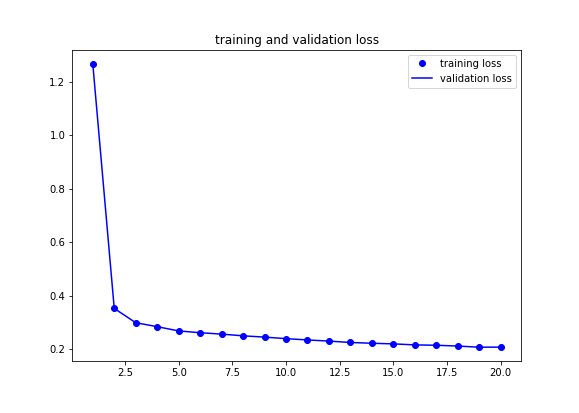

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook 

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Recurrent-Sequence Processing Model

This doesn't flatten the timeseries where we keep the sequence in mind

In [7]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 95s - loss: 0.3241 - val_loss: 0.2810
Epoch 2/20
500/500 [==============================] - 93s - loss: 0.2991 - val_loss: 0.2796
Epoch 3/20
500/500 [==============================] - 93s - loss: 0.2953 - val_loss: 0.2785
Epoch 4/20
500/500 [==============================] - 92s - loss: 0.2912 - val_loss: 0.2846
Epoch 5/20
500/500 [==============================] - 92s - loss: 0.2852 - val_loss: 0.2804
Epoch 6/20
500/500 [==============================] - 92s - loss: 0.2805 - val_loss: 0.2792
Epoch 7/20
500/500 [==============================] - 92s - loss: 0.2759 - val_loss: 0.2815
Epoch 8/20
500/500 [==============================] - 92s - loss: 0.2698 - val_loss: 0.2846
Epoch 9/20
500/500 [==============================] - 92s - loss: 0.2681 - val_loss: 0.2883
Epoch 10/20
500/500 [==============================] - 92s - loss: 0.2644 - val_loss: 0.2919
Epoch 11/20
500/500 [==============================] - 92s - loss: 0.2592 - val

In [13]:
#model.save('weather-ml-gru-base.h5')

ImportError: `save_model` requires h5py.

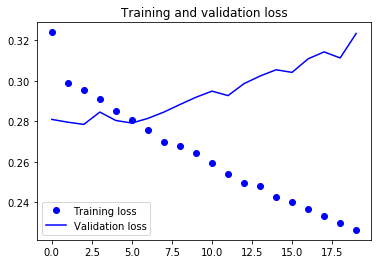

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Adding Dropout-regularized 

This avoids the overfitting during the first 30 epochs, scores aren't much lower than previously.

In [11]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 98s - loss: 0.3540 - val_loss: 0.2919
Epoch 2/40
500/500 [==============================] - 98s - loss: 0.3329 - val_loss: 0.2872
Epoch 3/40
500/500 [==============================] - 98s - loss: 0.3268 - val_loss: 0.2864
Epoch 4/40
500/500 [==============================] - 98s - loss: 0.3213 - val_loss: 0.2930
Epoch 5/40
500/500 [==============================] - 98s - loss: 0.3201 - val_loss: 0.2887
Epoch 6/40
500/500 [==============================] - 98s - loss: 0.3166 - val_loss: 0.2846
Epoch 7/40
500/500 [==============================] - 98s - loss: 0.3134 - val_loss: 0.2794
Epoch 8/40
500/500 [==============================] - 98s - loss: 0.3100 - val_loss: 0.2828
Epoch 9/40
500/500 [==============================] - 98s - loss: 0.3098 - val_loss: 0.2811
Epoch 10/40
500/500 [==============================] - 98s - loss: 0.3066 - val_loss: 0.2822
Epoch 11/40
500/500 [==============================] - 98s - loss: 0.3043 - val

In [ ]:
%matplotlib notebook 

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## Stacking Recurrent Layers

Increase the capacity of a network until overfitting is the primary problem

* Increase number of units in a layer

* Increase number of layers

The google translate algo is a stack of 7 large LSTM layers.

To stack recurrent layers all intermediate layers should return their full sequence of outputs (a 3d tensor) rather than output of the last timestep. 

```return_sequence=True```

In [ ]:
model = Sequential()
model.add(layers.GRU(32, 
                     return_sequences=True,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 187s - loss: 0.3401 - val_loss: 0.2895
Epoch 2/40
500/500 [==============================] - 187s - loss: 0.3176 - val_loss: 0.2874
Epoch 3/40
500/500 [==============================] - 186s - loss: 0.3115 - val_loss: 0.2829
Epoch 4/40
500/500 [==============================] - 186s - loss: 0.3077 - val_loss: 0.2778
Epoch 5/40
500/500 [==============================] - 186s - loss: 0.3060 - val_loss: 0.2875
Epoch 6/40
500/500 [==============================] - 186s - loss: 0.3004 - val_loss: 0.2856
Epoch 7/40
500/500 [==============================] - 186s - loss: 0.2990 - val_loss: 0.2808
Epoch 8/40
500/500 [==============================] - 186s - loss: 0.2951 - val_loss: 0.2793
Epoch 9/40
500/500 [==============================] - 186s - loss: 0.2925 - val_loss: 0.2777
Epoch 10/40
500/500 [==============================] - 186s - loss: 0.2900 - val_loss: 0.2738
Epoch 11/40
500/500 [==============================] - 186s - loss: 0

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()